<a href="https://colab.research.google.com/github/AndrewstheBuilder/FromScratch_NeuralNetworks/blob/main/MultiLayerPerceptron_FromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier

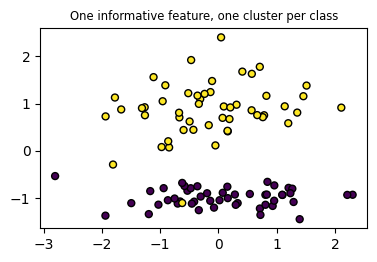

In [3]:
# Display Dataset to Train

plt.figure(figsize=(8, 8))
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)

plt.subplot(321)
plt.title("One informative feature, one cluster per class", fontsize="small")
X1, Y1 = make_classification(
    n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1
)
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=Y1, s=25, edgecolor="k")

# Import Dataset to Train
train_length = int(len(X1) * 0.8)
test_length = len(X1) - train_length
train_x, test_x, train_y, test_y = X1[0:train_length], X1[train_length:], Y1[0:train_length], Y1[train_length:]
# print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

In [61]:
# Multi Layer Perceptron Implementation
class Neuron:
  def __init__(self, weights, bias):
    self.weights = weights
    self.bias = bias

  def feedforward(self, inputs):
    total = np.dot(self.weights, inputs) + self.bias
    return total

class MLP:
  def __init__():
    '''
    '''
    pass

  def train():
    '''
    '''
    pass

  def predict():
    '''
    '''
    pass

# First Attempt at solving this dataset with MLP

- I can attempt to solve this as a regression problem first
- Take in X and try to predict the Y for the 100 examples of [Xi, Yi] that I have. It will find the line separating the two classes I believe!
- And after that I can try it as a classification problem.
- Then solve the MNIST dataset with my MLP
- Then try to do it with a different architecture like KANs

### Draft 1 **Perceptron**: Has backpropagation for learning but its adjusting the weights and biases without taking into account the error and what direction we should be adjusting the weights in.
- This setup allows the ML algorithm to learn any linear 2 variable function.

In [5]:
# Initialize weights start with the same values
weights = [1,1]
bias = 1

def relu(x):
  # if(x<=0):
  #   return 0
  # return 1
  return max(0, x)

def relu_deriv(output_relu):
  if(output_relu>=0):
    return 1
  return 0

weights = [1,1]
bias = 1
# n = Neuron(weights, None)
m = len(train_x)
iterations = 500
for n in range(iterations):
  for i in range(m):
    x1 = train_x[i][0]
    x2 = train_x[i][1]
    output = weights[0]*x1 + weights[1]*x2+ bias
    # Perform Loss Calculation
    error = (train_y[i] - output)
    # print('train_y[i]',train_y[i])
    # print('output',output)
    # Perform Back propagation to adjust the weight and bias
    weights[0] += -1 * x1
    weights[1] += -1 * x2
    bias += -1
  if(n%100 == 0):
    print('n:'+str(n)+' error:'+str(error))
# print(n)
# This implementation has the problem of exploding weights.
# I believe its because we are not taking into account the error. So we are adjusting
# the weight in the wrong direction

n:0 error:78.8961614364024
n:100 error:8254.626238484281
n:200 error:16430.356315532164
n:300 error:24606.086392580022
n:400 error:32781.81646962786


### Draft 2 **Perceptron**: There is no breaking symmetry here because the weights start out at the same value. But we introduce relu activation and use the error and learning rate to determine which direction and how much to adjust the weights and bias by.
- With a bias the weights start to cancel each other out and the bias starts to dominate the output
- Without a bias the weights find a equilibrium that leds to a inefficient solution. Its stuck in a pit. Forgot what this concept is called...

In [7]:
# Initialize weights start with the same values
weights = [1,1]
bias = 1

def relu(x):
  # if(x<=0):
  #   return 0
  # return 1
  return max(0, x)

def relu_deriv(output_relu):
  if(output_relu>=0):
    return 1
  return 0

m = len(train_x)
print('len(train_x)',m)
iterations = 500
lr = 0.001
for n in range(iterations):
  correct = 0
  for i in range(m):
    x1 = train_x[i][0]
    x2 = train_x[i][1]
    output = weights[0]*x1 + weights[1]*x2 + bias
    output_relu = relu(output)
    # Perform Loss Calculation
    error = (train_y[i] - output_relu)
    # print('error',error)
    if(error<0.5 and error > -0.5):
      correct += 1
    # Perform Back propagation to adjust the weight and bias
    weights[0] -= -1 * relu_deriv(output_relu) * x1 * lr * error
    weights[1] -= -1 * relu_deriv(output_relu) * x2 * lr * error
    bias += -1 * relu_deriv(output_relu) * lr * error
  if(n%10 == 0):
    print('----'*10)
    print('At the end of iteration:')
    print('n:'+str(n)+' Train Accuracy:'+str(correct/m))
    print('weights',weights)
    print('bias',bias)
    print('Sample input',train_x[m-1])
    print('Sample output f(x)=w1*x1 + w2*x2 + b --> ',output)
    # print('----'*10)
# print(n)

len(train_x) 80
----------------------------------------
At the end of iteration:
n:0 Train Accuracy:0.4375
weights [0.9435022119112313, 0.9694922547477354]
bias 1.0515288637294768
Sample input [-1.4948708  -1.10940252]
Sample output f(x)=w1*x1 + w2*x2 + b -->  -1.4344421903431257
----------------------------------------
At the end of iteration:
n:10 Train Accuracy:0.125
weights [0.48067356648934845, 0.7033928247390082]
bias 1.7475913377600363
Sample input [-1.4948708  -1.10940252]
Sample output f(x)=w1*x1 + w2*x2 + b -->  0.24931535318237574
----------------------------------------
At the end of iteration:
n:20 Train Accuracy:0.0
weights [0.2444431626973534, 0.5632603881251668]
bias 3.2369422047212173
Sample input [-1.4948708  -1.10940252]
Sample output f(x)=w1*x1 + w2*x2 + b -->  2.2522013709717124
----------------------------------------
At the end of iteration:
n:30 Train Accuracy:0.0
weights [0.17341863336934585, 0.4937331619438919]
bias 6.552961147846225
Sample input [-1.4948708 

### Draft 3 **Perceptron**: Introducing Breaking Symmetry
* By initializing weights and bias randomly
* It seems like now the bias has grown to cancel out the weights contribution. Its not immediately clear what breaking the symmetry has done. I wonder how they discovered this concept...

In [62]:
def relu(x):
  # if(x<=0):
  #   return 0
  # return 1
  return max(0, x)

def relu_deriv(output_relu):
  if(output_relu>=0):
    return 1
  return 0

# Initialize weights
np.random.seed(1)
weights = np.random.randn(2,)
bias = np.random.randn(1)[0]

m = len(train_x)
print('len(train_x)',m)
iterations = 6000
lr = 0.001
points = []
predicted = []
for n in range(iterations):
  correct = 0
  for i in range(m):
    x1 = train_x[i][0]
    x2 = train_x[i][1]
    output = weights[0]*x1 + weights[1]*x2 + bias
    output_relu = relu(output)
    # Perform Loss Calculation
    error = (train_y[i] - output_relu)
    # print('error',error)
    if(error<0.5 and error > -0.5):
      correct += 1
    if(n == iterations-1):
      points.append(train_x[i])
      predicted.append(output_relu)
        # correct_points.append(train_x[i])
        # print('correct_points after',correct_points)
        # print('train_x[i]',train_x[i])
    # Perform Back propagation to adjust the weight and bias
    weights[0] -= -1 * relu_deriv(output_relu) * x1 * lr * error
    weights[1] -= -1 * relu_deriv(output_relu) * x2 * lr * error
    bias += -1 * relu_deriv(output_relu) * lr * error
  if(n%2000 == 0 or n == iterations-1):
    print('----'*10)
    print('At the end of iteration:')
    print('n:'+str(n)+' Train Accuracy:'+str(correct/m))
    print('weights',weights)
    print('bias',bias)
    print('Sample input',train_x[m-1])
    print('Sample output f(x)=w1*x1 + w2*x2 + b --> ',output)
    # print('----'*10)
points = np.array(points)
predicted = np.array(predicted)
# print(n)
# print('correct_points',correct_points)
# print('np.array(correct_points)',np.array(correct_points))

len(train_x) 80
----------------------------------------
At the end of iteration:
n:0 Train Accuracy:0.35
weights [ 1.57844388 -0.56048108]
bias -0.5378402236144209
Sample input [-1.4948708  -1.10940252]
Sample output f(x)=w1*x1 + w2*x2 + b -->  -2.2756107625630486
----------------------------------------
At the end of iteration:
n:2000 Train Accuracy:0.4625
weights [-8.05289756 33.1271413 ]
bias -70.41517046762792
Sample input [-1.4948708  -1.10940252]
Sample output f(x)=w1*x1 + w2*x2 + b -->  -95.12846312094007
----------------------------------------
At the end of iteration:
n:4000 Train Accuracy:0.4625
weights [-16.8725385   61.72655062]
bias -138.72266633237138
Sample input [-1.4948708  -1.10940252]
Sample output f(x)=w1*x1 + w2*x2 + b -->  -181.9799920802414
----------------------------------------
At the end of iteration:
n:5999 Train Accuracy:0.4625
weights [-25.68777919  90.31114943]
bias -206.9957958184982
Sample input [-1.4948708  -1.10940252]
Sample output f(x)=w1*x1 + w2*x

In [57]:
print('train_x[:,0]',train_x[0])
# The first point train_x[0][0] is x in plt.scatter so when I solved for y
  # in y = mx+b y is train_x[:,1]
  # this affects if I divide weights[0]/weights[1] for m or weights[1]/weights[0]

train_x[:,0] [0.78259528 0.75226078]


predicted [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         8.84635844 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
f(x) = w1*x1 + w2*x2 + b
f(x) = -25.68777918617009*x1 + 90.31114942844327*x2 + -206.9957958184982


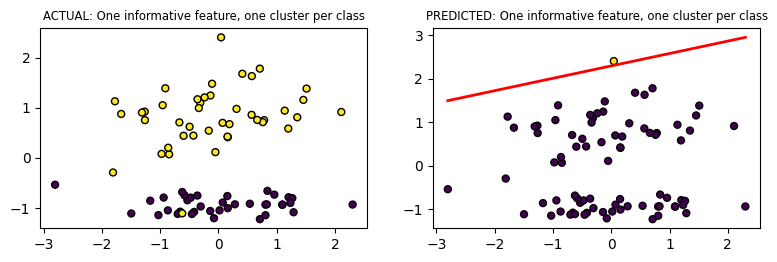

In [63]:
plt.figure(figsize=(8, 8))
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)

# Subplot for train data (Top Left)
plt.subplot(3, 2, 1)  # Use subplot grid (3 rows, 2 columns, position 1)
plt.title("ACTUAL: One informative feature, one cluster per class", fontsize="small")
plt.scatter(train_x[:, 0], train_x[:, 1], marker="o", c=train_y, s=25, edgecolor="k")

# Subplot for predicted data (Top Right)
plt.subplot(3, 2, 2)  # Use subplot grid (3 rows, 2 columns, position 2)
plt.title("PREDICTED: One informative feature, one cluster per class", fontsize="small")
plt.scatter(points[:, 0], points[:, 1], marker="o", c=predicted, s=25, edgecolor="k")

# Assuming the equation is y = mx + b (obtained from the model)
# Define range of x-values (adjust based on your data)
x_range = np.linspace(min(points[:, 0]), max(points[:, 0]), 100)
# Calculate predicted y-values for the range
predicted_y = -(weights[0]/weights[1]) * x_range - (bias/ weights[1])
# Overlay the line on the predicted data scatter plot
plt.plot(x_range, predicted_y, color='red', linewidth=2)

print('predicted',predicted)
print('f(x) = w1*x1 + w2*x2 + b')
print('f(x) = '+str(weights[0])+'*x1 + '+str(weights[1])+'*x2 + ' + str(bias))
# print('points.shape',points.shape)
# print('predicted.shape',predicted.shape)
# print('train_x.shape',train_x.shape)
# print('train_y.shape',train_y.shape)


# TODO COMPLETED: draw last iteration MLP predictions on training set on graph stopped here
  # I want to see the function that its learning
  # Since the function that my network is able to learn is linear it does not look like
  # it can learn what is displayed on the graph
  # equation is f(x) = w1*x1 + w2*x2 + b

### Draft 4 New and Improved **Perceptron**: 100% on test set!!
* Since its a Perceptron I couldn't use back prop it didn't work effectively for some reason?? I had to use the Perceptron Convergence Theorem.
  - Investigate why back prop does not work for Perceptrons?

In [94]:
def relu(x):
  if(x<=0):
    return 0
  return 1

# Parameter Initialization
np.random.seed(1)
weights = np.random.randn(2,)
bias = np.random.randn(1)[0]

# Training
m = len(train_x)
print('len(train_x)',m)
iterations = 100
lr = 0.001
points = []
predicted = []
for n in range(iterations):
  correct = 0
  for i in range(m):
    x1 = train_x[i][0]
    x2 = train_x[i][1]
    output = weights[0]*x1 + weights[1]*x2 + bias
    output_relu = relu(output)
    # Perform Loss Calculation
    error = (train_y[i] - output_relu)
    if(error<0.5 and error > -0.5):
      correct += 1
    if(n == iterations-1):
      points.append(train_x[i])
      predicted.append(output_relu)
    # Perform Perceptron Convergence Theorem
    weights[0] += lr*error*x1
    weights[1] += lr*error*x2
    bias += lr*error
  if(n%20 == 0 or n-1 == iterations):
    print('----'*10)
    print('At the end of iteration:')
    print('n:'+str(n)+' Train Accuracy:'+str(correct/m))
    print('weights',weights)
    print('bias',bias)
    print('Sample input',train_x[m-1])
    print('Sample output f(x)=w1*x1 + w2*x2 + b --> ',output)

points = np.array(points)
predicted = np.array(predicted)

len(train_x) 80
----------------------------------------
At the end of iteration:
n:0 Train Accuracy:0.325
weights [ 1.59379172 -0.56546788]
bias -0.5141717522634557
Sample input [-1.4948708  -1.10940252]
Sample output f(x)=w1*x1 + w2*x2 + b -->  -2.2693529490032924
----------------------------------------
At the end of iteration:
n:20 Train Accuracy:0.5
weights [0.95437752 0.18860635]
bias -0.22117175226345542
Sample input [-1.4948708  -1.10940252]
Sample output f(x)=w1*x1 + w2*x2 + b -->  -1.8570831933070053
----------------------------------------
At the end of iteration:
n:40 Train Accuracy:0.8125
weights [0.40406823 0.54240962]
bias -0.04817175226345527
Sample input [-1.4948708  -1.10940252]
Sample output f(x)=w1*x1 + w2*x2 + b -->  -1.253952151466189
----------------------------------------
At the end of iteration:
n:60 Train Accuracy:0.925
weights [0.21726968 0.56322658]
bias 0.05582824773654481
Sample input [-1.4948708  -1.10940252]
Sample output f(x)=w1*x1 + w2*x2 + b -->  -0.

In [95]:
# Test on test set
m_test = len(test_x)
correct=0
for i in range(m_test):
  x1 = test_x[i][0]
  x2 = test_x[i][1]
  output = weights[0]*x1 + weights[1]*x2 + bias
  output_relu = relu(output)
  # Perform Loss Calculation
  error = (test_y[i] - output_relu)
  # print('error',error)
  if(error<0.5 and error > -0.5):
    correct += 1
print(str(correct/m_test))

1.0


predicted [1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 0 0 1
 1 0 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 1 0
 0 0 0 0 1 0]
f(x) = w1*x1 + w2*x2 + b
f(x) = 0.09180275474727334*x1 + 0.5135660851518635*x2 + 0.15682824773654488


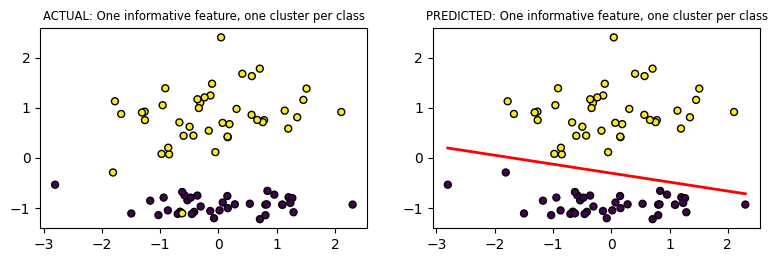

In [96]:
plt.figure(figsize=(8, 8))
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)

# Subplot for train data (Top Left)
plt.subplot(3, 2, 1)  # Use subplot grid (3 rows, 2 columns, position 1)
plt.title("ACTUAL: One informative feature, one cluster per class", fontsize="small")
plt.scatter(train_x[:, 0], train_x[:, 1], marker="o", c=train_y, s=25, edgecolor="k")

# Subplot for predicted data (Top Right)
plt.subplot(3, 2, 2)  # Use subplot grid (3 rows, 2 columns, position 2)
plt.title("PREDICTED: One informative feature, one cluster per class", fontsize="small")
plt.scatter(points[:, 0], points[:, 1], marker="o", c=predicted, s=25, edgecolor="k")

# Assuming the equation is y = mx + b (obtained from the model)
# Overlay the line on the predicted data scatter plot
x_range = np.linspace(min(points[:, 0]), max(points[:, 0]), 100)
predicted_y = -(weights[0]/weights[1]) * x_range - (bias/ weights[1])
plt.plot(x_range, predicted_y, color='red', linewidth=2)

print('predicted',predicted)
print('f(x) = w1*x1 + w2*x2 + b')
print('f(x) = '+str(weights[0])+'*x1 + '+str(weights[1])+'*x2 + ' + str(bias))

## Using existing SKlearn MLP Implementation

In [ ]:
clf = MLPClassifier(random_state=1, max_iter=1000, hidden_layer_sizes=(1,)).fit(train_x, train_y)

In [ ]:
clf.score(test_x, test_y)

0.45

In [ ]:
clf.predict(test_x)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print('test_y',test_y)

test_y [1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 0 0 0]
